### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from model import *

In [6]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger

In [7]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 1.14.0


In [8]:
K.set_image_data_format('channels_first')

In [9]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [10]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\Rosana\Documents\Mestrado\dissertacao\codigo_unet\scripts\model.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [11]:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

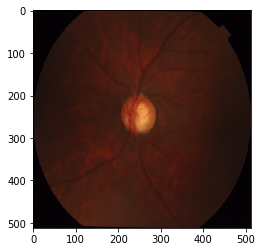

(50, 512, 512, 3)


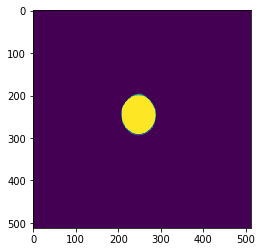

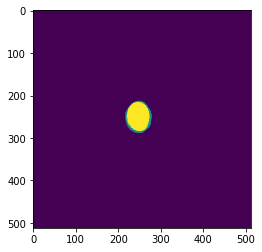

In [26]:
plt.imshow(img_train[0])
plt.show()
print(img_train.shape)
plt.imshow(np.squeeze(disc_train[0]))
plt.show()
plt.imshow(np.squeeze(cup_train[0]))
plt.show()

In [27]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

In [57]:
gen = data_generator(img_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

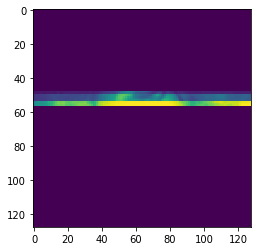

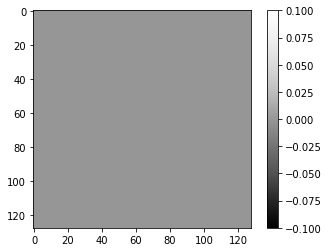

In [58]:
fig = plt.imshow(batch[0][0][0])
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); 
plt.colorbar(); 
plt.show()

In [32]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))

In [33]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [34]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

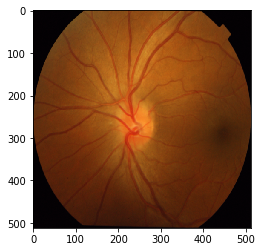

51


In [35]:
plt.imshow(img_test[50])
plt.show()
print(len(img_test))

In [36]:
X_valid, Y_valid = next(data_generator(img_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

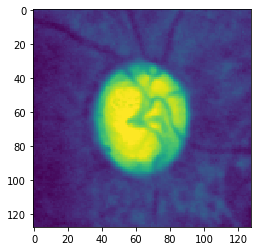

50


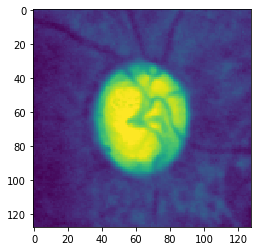

In [49]:
plt.imshow(X_valid[0][0])
plt.show()
print(len(X_valid))
batch_X = X_valid[0:0 + 1]
plt.imshow(batch_X[0][0])
plt.show()

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [76]:
history = model.fit_generator(data_generator(img_train, cup_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Y_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500
99/99 [==============================] - 35s 357ms/step - loss: 1.5120 - mean_IOU_gpu: 0.0141 - dice_metric: 0.0274 - val_loss: 1.4382 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 2/500
99/99 [==============================] - 38s 383ms/step - loss: 1.3795 - mean_IOU_gpu: 0.0044 - dice_metric: 0.0086 - val_loss: 1.3426 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 3/500
99/99 [==============================] - 41s 416ms/step - loss: 1.3588 - mean_IOU_gpu: 0.0395 - dice_metric: 0.0707 - val_loss: 1.1749 - val_mean_IOU_gpu: 0.0178 - val_dice_metric: 0.0297
Epoch 4/500
99/99 [==============================] - 43s 435ms/step - loss: 1.1466 - mean_IOU_gpu: 0.1459 - dice_metric: 0.2332 - val_loss: 0.8551 - val_mean_IOU_gpu: 0.1657 - val_dice_metric: 0.2225
Epoch 5/500
99/99 [==============================] - 43s 435ms/step - loss: 0.8622 - mean_IOU_gpu: 0.2903 - dice_metric: 0.4174 - val_loss: 0.4970 - val_mean_IOU_gpu: 0.3198 - val_dice

Epoch 42/500
99/99 [==============================] - 45s 456ms/step - loss: 0.1888 - mean_IOU_gpu: 0.6840 - dice_metric: 0.8028 - val_loss: 0.9204 - val_mean_IOU_gpu: 0.3136 - val_dice_metric: 0.4206
Epoch 43/500
99/99 [==============================] - 42s 422ms/step - loss: 0.2019 - mean_IOU_gpu: 0.6750 - dice_metric: 0.7950 - val_loss: 1.6791 - val_mean_IOU_gpu: 0.1762 - val_dice_metric: 0.2453
Epoch 44/500
99/99 [==============================] - 42s 423ms/step - loss: 0.1777 - mean_IOU_gpu: 0.7025 - dice_metric: 0.8155 - val_loss: 0.7449 - val_mean_IOU_gpu: 0.3711 - val_dice_metric: 0.4895
Epoch 45/500
99/99 [==============================] - 41s 410ms/step - loss: 0.1838 - mean_IOU_gpu: 0.6958 - dice_metric: 0.8102 - val_loss: 0.4149 - val_mean_IOU_gpu: 0.5119 - val_dice_metric: 0.6416
Epoch 46/500
99/99 [==============================] - 44s 448ms/step - loss: 0.2057 - mean_IOU_gpu: 0.6725 - dice_metric: 0.7913 - val_loss: 1.1998 - val_mean_IOU_gpu: 0.2525 - val_dice_metric: 0.

Epoch 83/500
99/99 [==============================] - 41s 409ms/step - loss: 0.1730 - mean_IOU_gpu: 0.6921 - dice_metric: 0.8108 - val_loss: 0.7352 - val_mean_IOU_gpu: 0.3490 - val_dice_metric: 0.4571
Epoch 84/500
99/99 [==============================] - 42s 423ms/step - loss: 0.1665 - mean_IOU_gpu: 0.7080 - dice_metric: 0.8201 - val_loss: 1.5265 - val_mean_IOU_gpu: 0.1729 - val_dice_metric: 0.2423
Epoch 85/500
99/99 [==============================] - 41s 413ms/step - loss: 0.1691 - mean_IOU_gpu: 0.7017 - dice_metric: 0.8161 - val_loss: 1.1285 - val_mean_IOU_gpu: 0.2151 - val_dice_metric: 0.2973
Epoch 86/500
99/99 [==============================] - 40s 406ms/step - loss: 0.1843 - mean_IOU_gpu: 0.6849 - dice_metric: 0.8026 - val_loss: 1.3480 - val_mean_IOU_gpu: 0.1666 - val_dice_metric: 0.2343
Epoch 87/500
99/99 [==============================] - 41s 418ms/step - loss: 0.1556 - mean_IOU_gpu: 0.7231 - dice_metric: 0.8300 - val_loss: 1.0776 - val_mean_IOU_gpu: 0.2193 - val_dice_metric: 0.

Epoch 124/500
99/99 [==============================] - 42s 425ms/step - loss: 0.1343 - mean_IOU_gpu: 0.7458 - dice_metric: 0.8479 - val_loss: 2.3775 - val_mean_IOU_gpu: 0.0785 - val_dice_metric: 0.1174
Epoch 125/500
99/99 [==============================] - 40s 406ms/step - loss: 0.1433 - mean_IOU_gpu: 0.7288 - dice_metric: 0.8365 - val_loss: 1.2772 - val_mean_IOU_gpu: 0.1879 - val_dice_metric: 0.2683
Epoch 126/500
99/99 [==============================] - 41s 410ms/step - loss: 0.1274 - mean_IOU_gpu: 0.7556 - dice_metric: 0.8545 - val_loss: 3.1069 - val_mean_IOU_gpu: 0.0216 - val_dice_metric: 0.0344
Epoch 127/500
99/99 [==============================] - 42s 420ms/step - loss: 0.1262 - mean_IOU_gpu: 0.7564 - dice_metric: 0.8557 - val_loss: 2.2611 - val_mean_IOU_gpu: 0.0829 - val_dice_metric: 0.1264
Epoch 128/500
99/99 [==============================] - 41s 413ms/step - loss: 0.1433 - mean_IOU_gpu: 0.7354 - dice_metric: 0.8403 - val_loss: 1.6016 - val_mean_IOU_gpu: 0.1541 - val_dice_metri

Epoch 205/500
99/99 [==============================] - 40s 409ms/step - loss: 0.1182 - mean_IOU_gpu: 0.7654 - dice_metric: 0.8619 - val_loss: 1.4421 - val_mean_IOU_gpu: 0.2182 - val_dice_metric: 0.2920
Epoch 206/500
99/99 [==============================] - 42s 422ms/step - loss: 0.1294 - mean_IOU_gpu: 0.7489 - dice_metric: 0.8512 - val_loss: 1.8528 - val_mean_IOU_gpu: 0.1642 - val_dice_metric: 0.2250
Epoch 207/500
99/99 [==============================] - 43s 433ms/step - loss: 0.1083 - mean_IOU_gpu: 0.7753 - dice_metric: 0.8705 - val_loss: 1.0189 - val_mean_IOU_gpu: 0.3302 - val_dice_metric: 0.4211
Epoch 208/500
99/99 [==============================] - 42s 428ms/step - loss: 0.0980 - mean_IOU_gpu: 0.7943 - dice_metric: 0.8818 - val_loss: 1.6945 - val_mean_IOU_gpu: 0.1859 - val_dice_metric: 0.2527
Epoch 209/500
99/99 [==============================] - 44s 441ms/step - loss: 0.1063 - mean_IOU_gpu: 0.7867 - dice_metric: 0.8761 - val_loss: 1.8542 - val_mean_IOU_gpu: 0.1934 - val_dice_metri

Epoch 286/500
99/99 [==============================] - 47s 479ms/step - loss: 0.1082 - mean_IOU_gpu: 0.7771 - dice_metric: 0.8706 - val_loss: 1.1793 - val_mean_IOU_gpu: 0.3017 - val_dice_metric: 0.3855
Epoch 287/500
99/99 [==============================] - 47s 479ms/step - loss: 0.0865 - mean_IOU_gpu: 0.8123 - dice_metric: 0.8938 - val_loss: 1.3189 - val_mean_IOU_gpu: 0.3011 - val_dice_metric: 0.3823
Epoch 288/500
99/99 [==============================] - 48s 483ms/step - loss: 0.1035 - mean_IOU_gpu: 0.7845 - dice_metric: 0.8753 - val_loss: 1.8686 - val_mean_IOU_gpu: 0.1974 - val_dice_metric: 0.2555
Epoch 289/500
99/99 [==============================] - 48s 483ms/step - loss: 0.0861 - mean_IOU_gpu: 0.8099 - dice_metric: 0.8929 - val_loss: 1.7407 - val_mean_IOU_gpu: 0.2308 - val_dice_metric: 0.2958
Epoch 290/500
99/99 [==============================] - 48s 484ms/step - loss: 0.0948 - mean_IOU_gpu: 0.7967 - dice_metric: 0.8843 - val_loss: 1.1670 - val_mean_IOU_gpu: 0.3028 - val_dice_metri

Epoch 367/500
99/99 [==============================] - 48s 488ms/step - loss: 0.0909 - mean_IOU_gpu: 0.8042 - dice_metric: 0.8886 - val_loss: 1.2576 - val_mean_IOU_gpu: 0.3305 - val_dice_metric: 0.4132
Epoch 368/500
99/99 [==============================] - 48s 480ms/step - loss: 0.0982 - mean_IOU_gpu: 0.7926 - dice_metric: 0.8811 - val_loss: 1.5203 - val_mean_IOU_gpu: 0.2755 - val_dice_metric: 0.3470
Epoch 369/500
99/99 [==============================] - 48s 480ms/step - loss: 0.1055 - mean_IOU_gpu: 0.7781 - dice_metric: 0.8722 - val_loss: 0.7831 - val_mean_IOU_gpu: 0.4303 - val_dice_metric: 0.5352
Epoch 370/500
99/99 [==============================] - 48s 489ms/step - loss: 0.1023 - mean_IOU_gpu: 0.7861 - dice_metric: 0.8763 - val_loss: 1.0261 - val_mean_IOU_gpu: 0.3441 - val_dice_metric: 0.4344
Epoch 371/500
99/99 [==============================] - 48s 485ms/step - loss: 0.1006 - mean_IOU_gpu: 0.7863 - dice_metric: 0.8773 - val_loss: 0.9649 - val_mean_IOU_gpu: 0.3663 - val_dice_metri

Epoch 448/500
99/99 [==============================] - 49s 490ms/step - loss: 0.0792 - mean_IOU_gpu: 0.8240 - dice_metric: 0.9015 - val_loss: 1.3675 - val_mean_IOU_gpu: 0.2961 - val_dice_metric: 0.3783
Epoch 449/500
99/99 [==============================] - 48s 482ms/step - loss: 0.0854 - mean_IOU_gpu: 0.8144 - dice_metric: 0.8957 - val_loss: 1.7013 - val_mean_IOU_gpu: 0.2764 - val_dice_metric: 0.3536
Epoch 450/500
99/99 [==============================] - 52s 521ms/step - loss: 0.0840 - mean_IOU_gpu: 0.8157 - dice_metric: 0.8964 - val_loss: 0.6327 - val_mean_IOU_gpu: 0.4927 - val_dice_metric: 0.5968
Epoch 451/500
99/99 [==============================] - 48s 480ms/step - loss: 0.0931 - mean_IOU_gpu: 0.8006 - dice_metric: 0.8864 - val_loss: 1.1640 - val_mean_IOU_gpu: 0.3432 - val_dice_metric: 0.4261
Epoch 452/500
99/99 [==============================] - 48s 485ms/step - loss: 0.0826 - mean_IOU_gpu: 0.8179 - dice_metric: 0.8979 - val_loss: 0.7458 - val_mean_IOU_gpu: 0.4492 - val_dice_metri

### Visual check

image #0


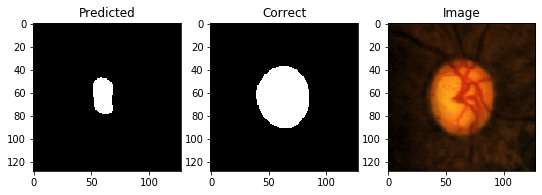

IOU: 0.23829130828380585
Dice: 0.3848711554447215
image #1


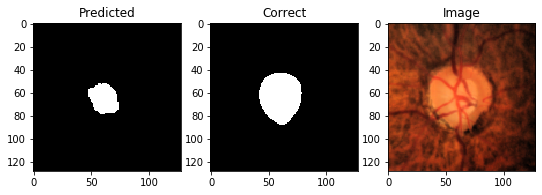

IOU: 0.41543257236480713
Dice: 0.5870044052863436
image #2


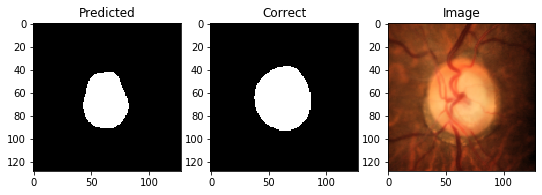

IOU: 0.7076707482337952
Dice: 0.8288140235551904
image #3


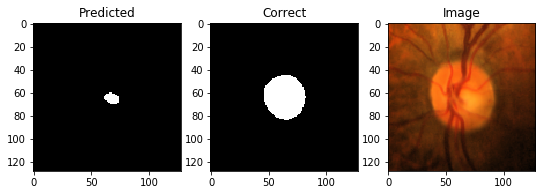

IOU: 0.08948339521884918
Dice: 0.1642675698560542
image #4


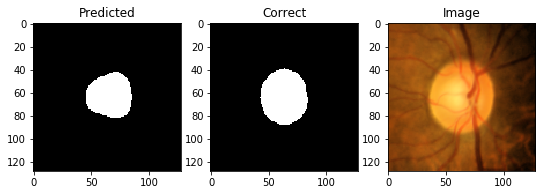

IOU: 0.751091718673706
Dice: 0.85785536159601
image #5


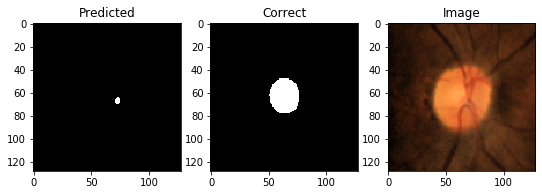

IOU: 0.028846153989434242
Dice: 0.056074766355140186
image #6


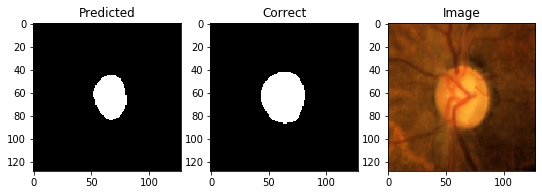

IOU: 0.6350746154785156
Dice: 0.776814240073026
image #7


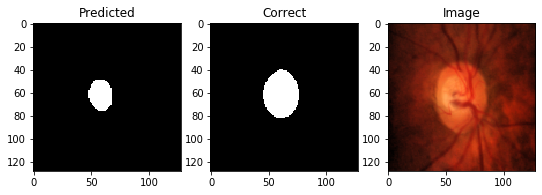

IOU: 0.4395604431629181
Dice: 0.6106870229007634
image #8


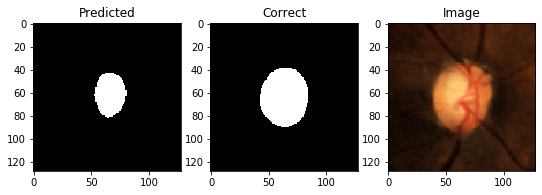

IOU: 0.47882354259490967
Dice: 0.6475735879077168
image #9


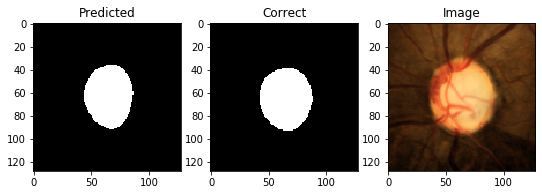

IOU: 0.8660049438476562
Dice: 0.9281914893617021
image #10


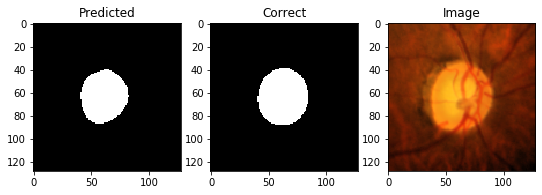

IOU: 0.8539977073669434
Dice: 0.92125
image #11


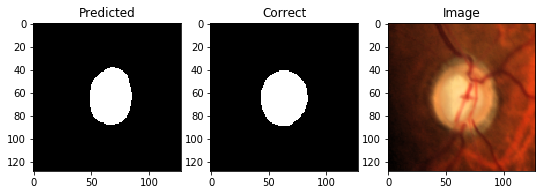

IOU: 0.784907877445221
Dice: 0.8794940079893475
image #12


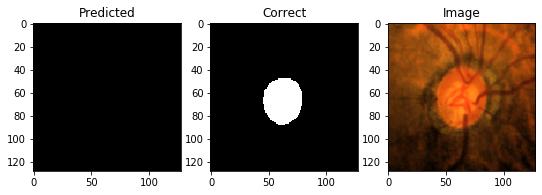

IOU: 0.0
Dice: 0.0
image #13


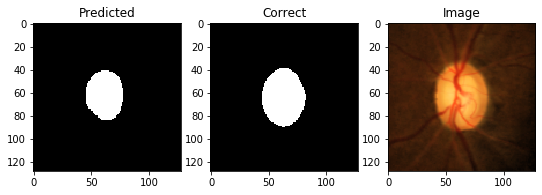

IOU: 0.7540872097015381
Dice: 0.8598058252427184
image #14


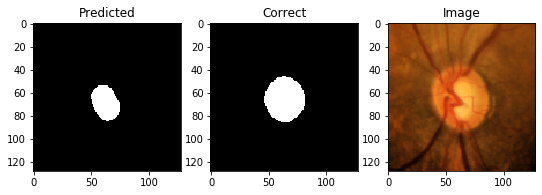

IOU: 0.533707857131958
Dice: 0.6959706959706959
image #15


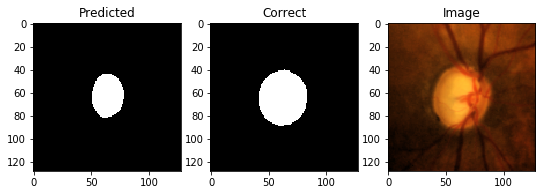

IOU: 0.5225846767425537
Dice: 0.6864441697569015
image #16


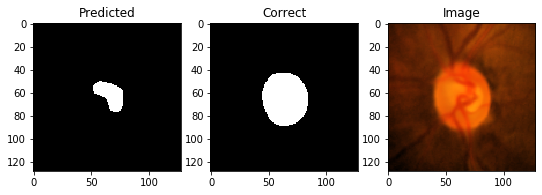

IOU: 0.2904762029647827
Dice: 0.45018450184501846
image #17


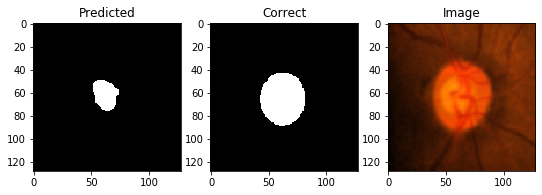

IOU: 0.3118355870246887
Dice: 0.47541869259859537
image #18


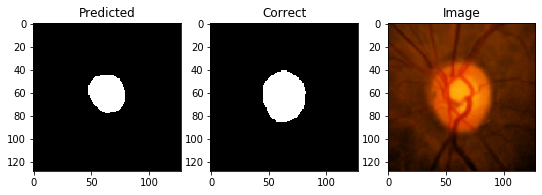

IOU: 0.6475600600242615
Dice: 0.7860836859426422
image #19


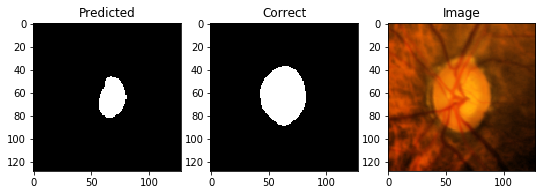

IOU: 0.40631037950515747
Dice: 0.5778388278388278
image #20


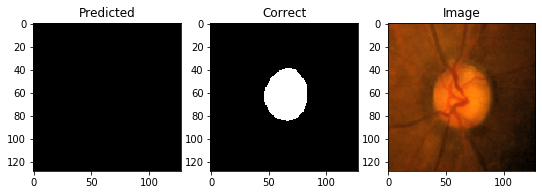

IOU: 0.0
Dice: 0.0
image #21


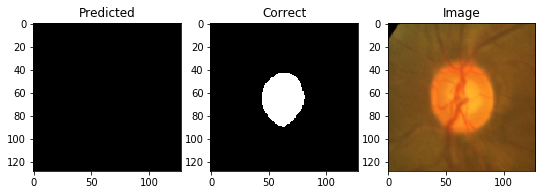

IOU: 0.0
Dice: 0.0
image #22


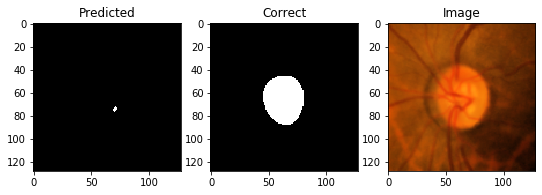

IOU: 0.010152284055948257
Dice: 0.020100502512562814
image #23


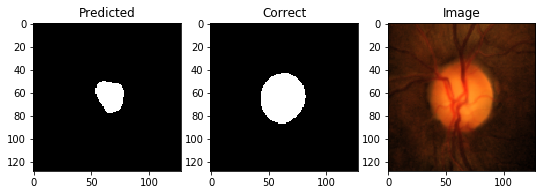

IOU: 0.39453718066215515
Dice: 0.5658324265505985
image #24


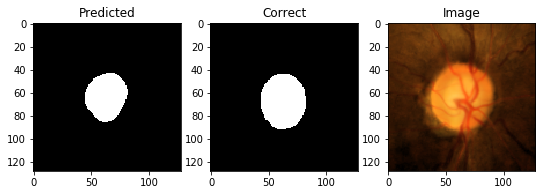

IOU: 0.7514753937721252
Dice: 0.8581055784350431
image #25


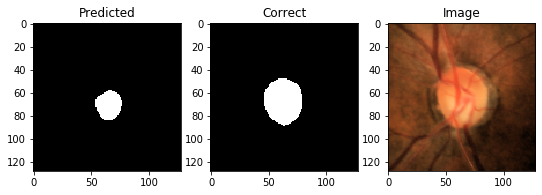

IOU: 0.4303317666053772
Dice: 0.6017229953611664
image #26


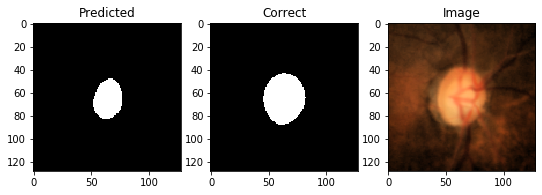

IOU: 0.5447220206260681
Dice: 0.7052686489306208
image #27


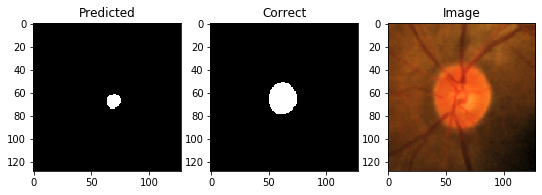

IOU: 0.2178770899772644
Dice: 0.3577981651376147
image #28


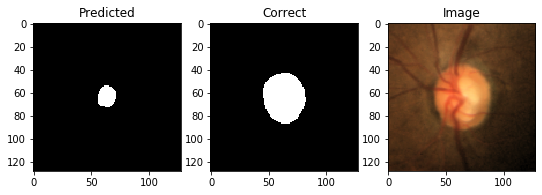

IOU: 0.19285714626312256
Dice: 0.32335329341317365
image #29


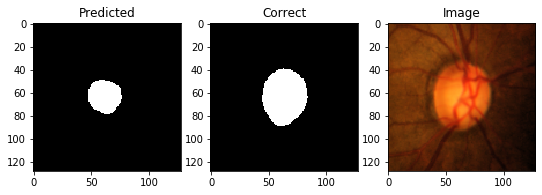

IOU: 0.4537474811077118
Dice: 0.6242452392011147
image #30


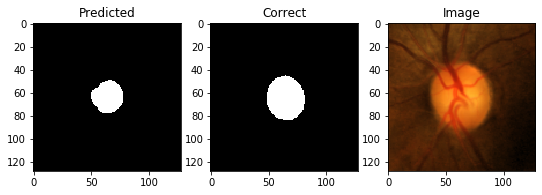

IOU: 0.6026026010513306
Dice: 0.7520299812617114
image #31


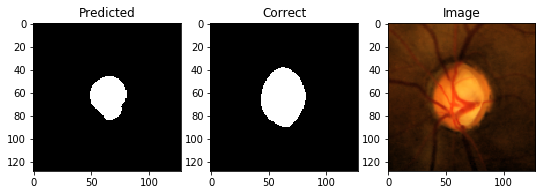

IOU: 0.5904255509376526
Dice: 0.7424749163879598
image #32


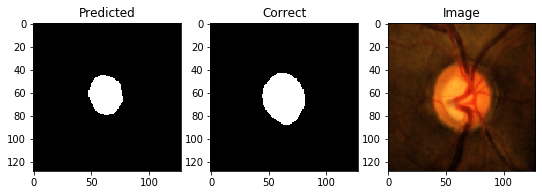

IOU: 0.6343223452568054
Dice: 0.7762512266928361
image #33


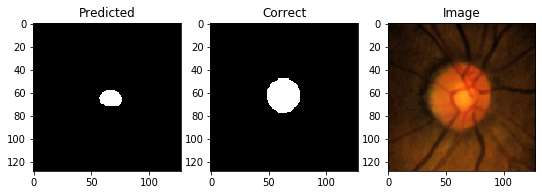

IOU: 0.32894736528396606
Dice: 0.49504950495049505
image #34


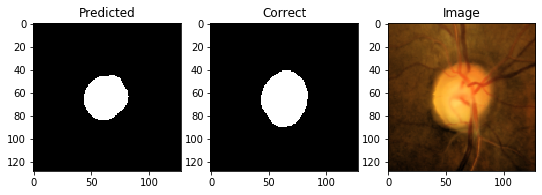

IOU: 0.7575957775115967
Dice: 0.8620819240886884
image #35


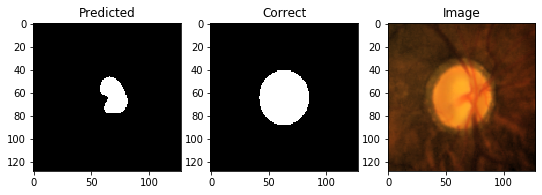

IOU: 0.33496931195259094
Dice: 0.5018382352941176
image #36


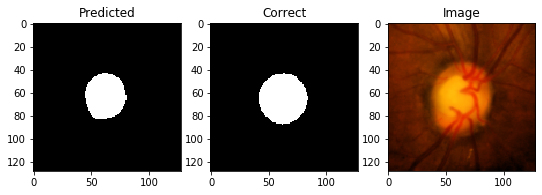

IOU: 0.7689133286476135
Dice: 0.8693623639191291
image #37


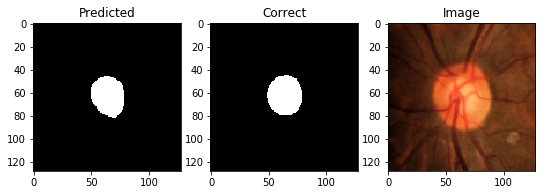

IOU: 0.8933030366897583
Dice: 0.9436450839328537
image #38


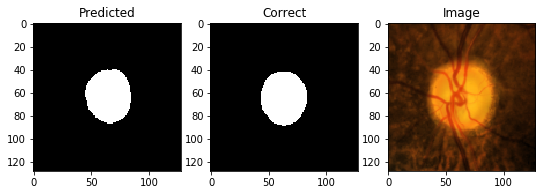

IOU: 0.8602150678634644
Dice: 0.9248554913294798
image #39


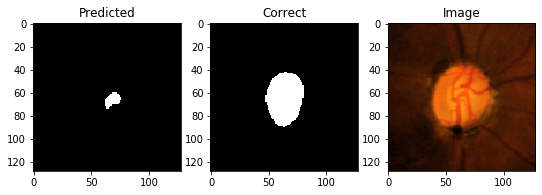

IOU: 0.10726351290941238
Dice: 0.19374523264683446
image #40


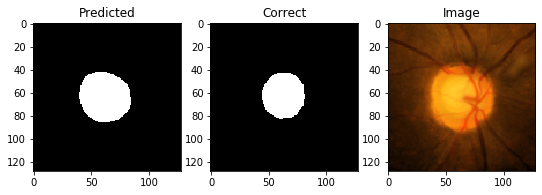

IOU: 0.7358730435371399
Dice: 0.8478419897585955
image #41


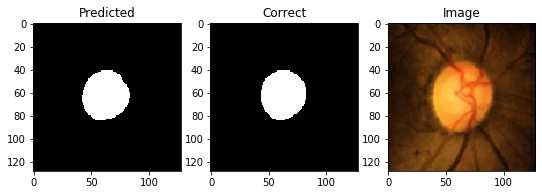

IOU: 0.9350000023841858
Dice: 0.9664082687338501
image #42


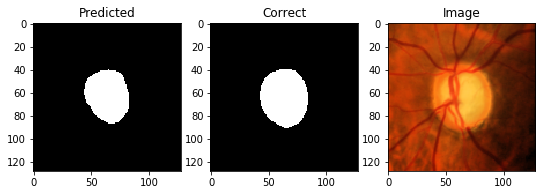

IOU: 0.8349339962005615
Dice: 0.910042525351652
image #43


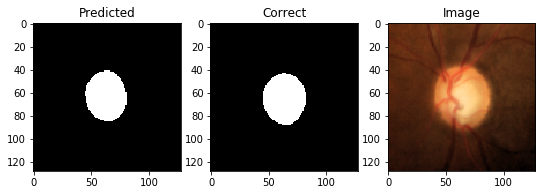

IOU: 0.8428362607955933
Dice: 0.9147163823879413
image #44


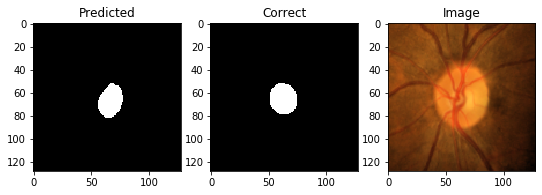

IOU: 0.6091205477714539
Dice: 0.757085020242915
image #45


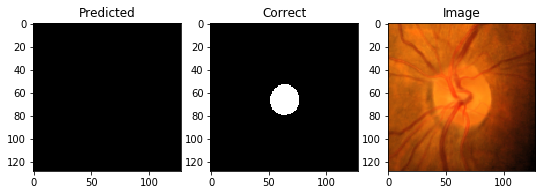

IOU: 0.0
Dice: 0.0
image #46


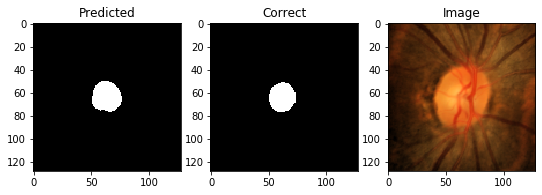

IOU: 0.8165467381477356
Dice: 0.899009900990099
image #47


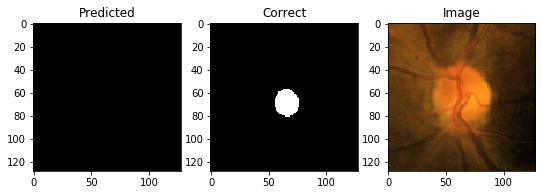

IOU: 0.0
Dice: 0.0
image #48


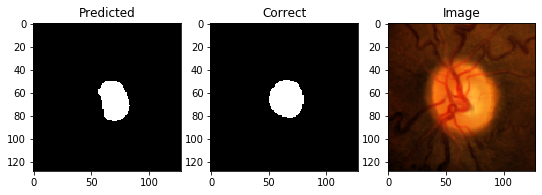

IOU: 0.6875
Dice: 0.8148148148148148
image #49


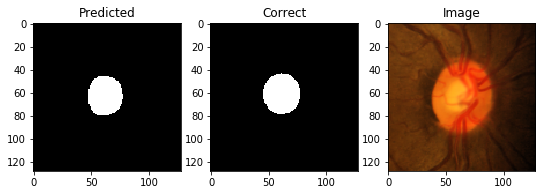

IOU: 0.8606645464897156
Dice: 0.9251152073732719


In [79]:
pred_iou, pred_dice = [], []
pred_cup = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_cup.append(pred)
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [80]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.4990496
0.6065487789844111


### Loading model

In [69]:
X_valid, Z_valid = next(data_generator_test(img_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [70]:
history = model.fit_generator(data_generator(img_train, disc_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Z_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/1
99/99 [==============================] - 33s 337ms/step - loss: 0.9925 - mean_IOU_gpu: 0.0154 - dice_metric: 0.0301 - val_loss: 0.9767 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


image #0


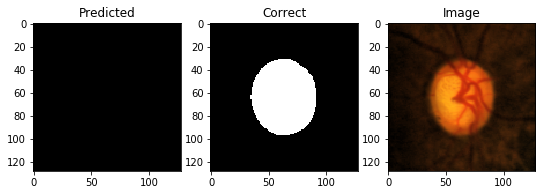

IOU: 0.0
Dice: 0.0
image #1


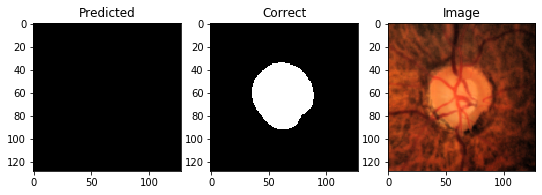

IOU: 0.0
Dice: 0.0
image #2


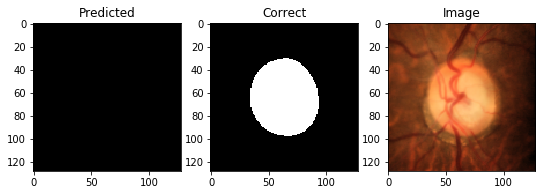

IOU: 0.0
Dice: 0.0
image #3


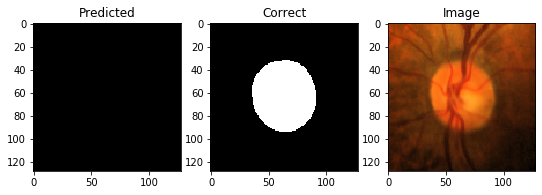

IOU: 0.0
Dice: 0.0
image #4


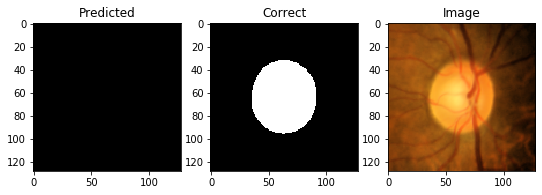

IOU: 0.0
Dice: 0.0
image #5


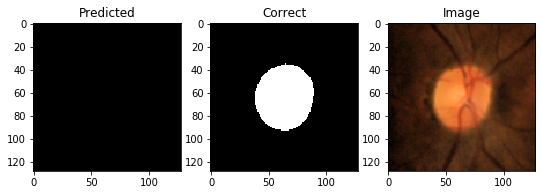

IOU: 0.0
Dice: 0.0
image #6


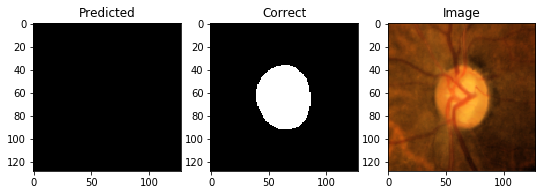

IOU: 0.0
Dice: 0.0
image #7


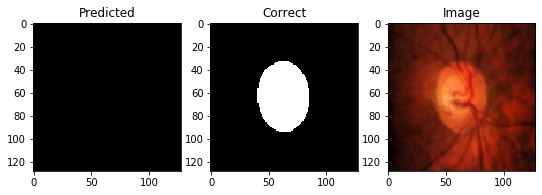

IOU: 0.0
Dice: 0.0
image #8


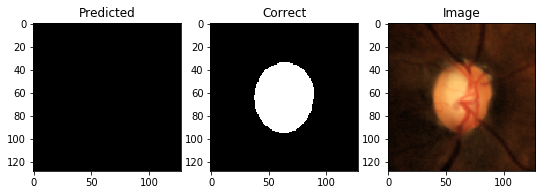

IOU: 0.0
Dice: 0.0
image #9


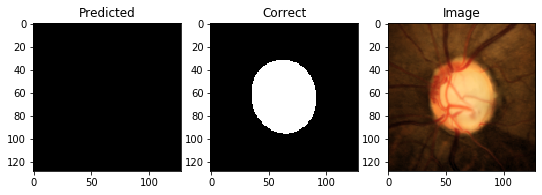

IOU: 0.0
Dice: 0.0
image #10


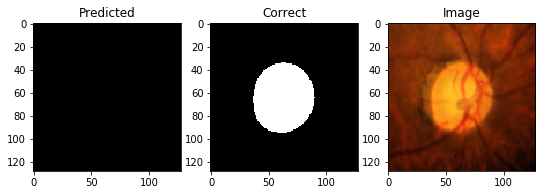

IOU: 0.0
Dice: 0.0
image #11


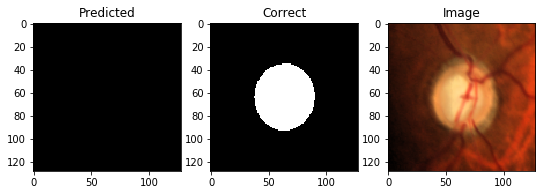

IOU: 0.0
Dice: 0.0
image #12


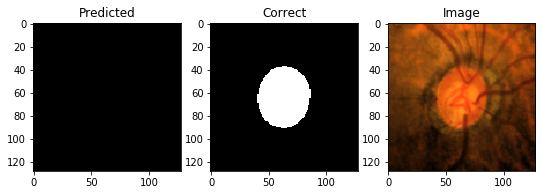

IOU: 0.0
Dice: 0.0
image #13


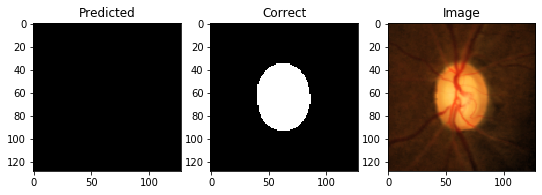

IOU: 0.0
Dice: 0.0
image #14


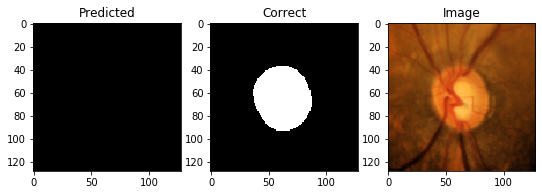

IOU: 0.0
Dice: 0.0
image #15


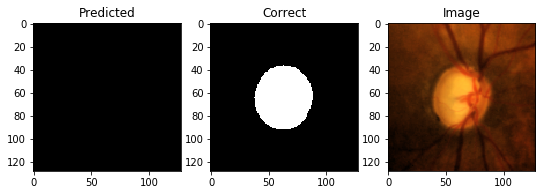

IOU: 0.0
Dice: 0.0
image #16


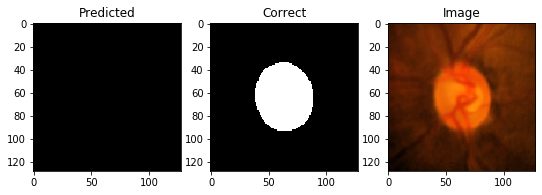

IOU: 0.0
Dice: 0.0
image #17


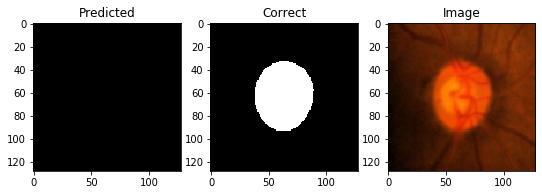

IOU: 0.0
Dice: 0.0
image #18


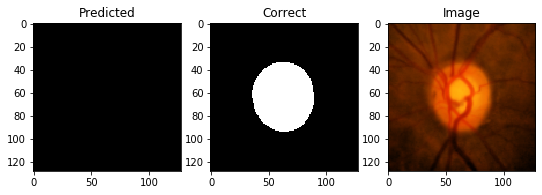

IOU: 0.0
Dice: 0.0
image #19


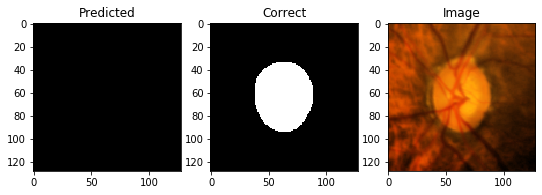

IOU: 0.0
Dice: 0.0
image #20


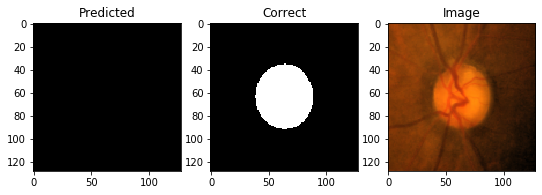

IOU: 0.0
Dice: 0.0
image #21


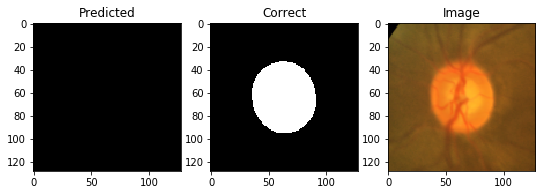

IOU: 0.0
Dice: 0.0
image #22


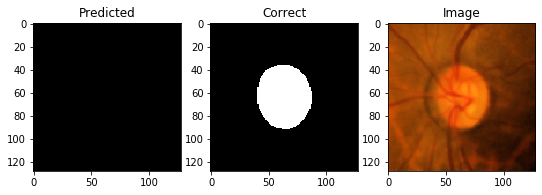

IOU: 0.0
Dice: 0.0
image #23


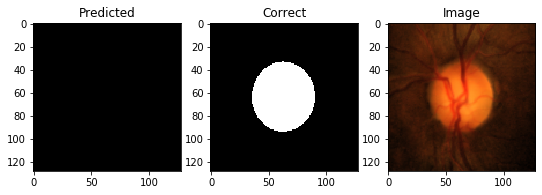

IOU: 0.0
Dice: 0.0
image #24


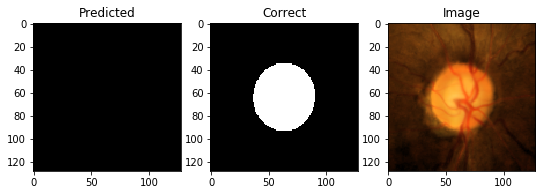

IOU: 0.0
Dice: 0.0
image #25


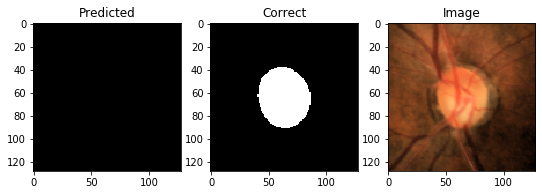

IOU: 0.0
Dice: 0.0
image #26


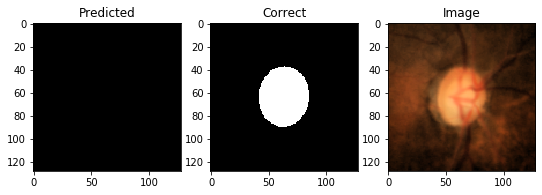

IOU: 0.0
Dice: 0.0
image #27


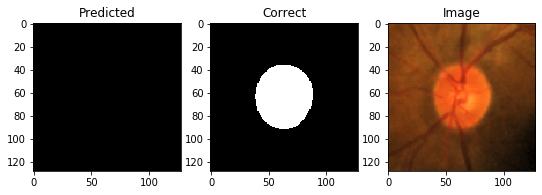

IOU: 0.0
Dice: 0.0
image #28


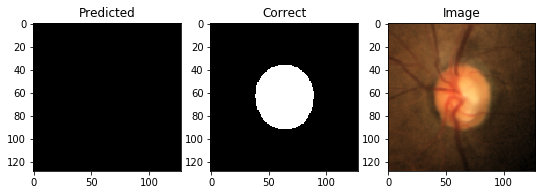

IOU: 0.0
Dice: 0.0
image #29


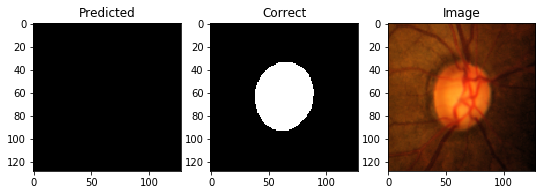

IOU: 0.0
Dice: 0.0
image #30


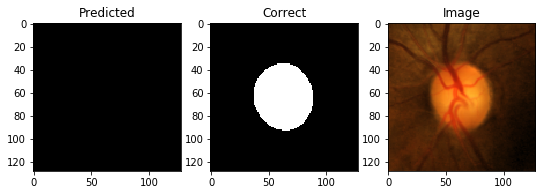

IOU: 0.0
Dice: 0.0
image #31


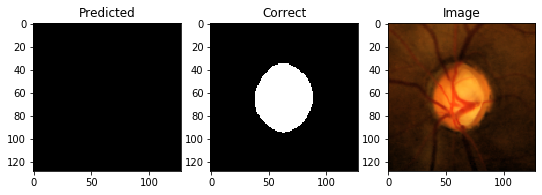

IOU: 0.0
Dice: 0.0
image #32


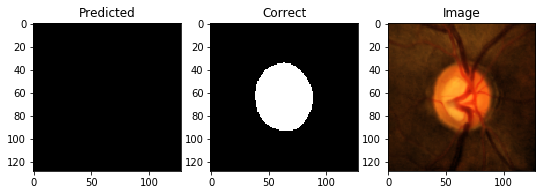

IOU: 0.0
Dice: 0.0
image #33


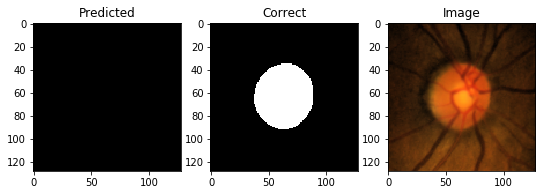

IOU: 0.0
Dice: 0.0
image #34


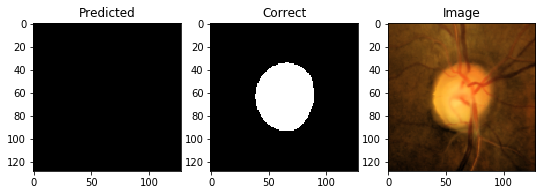

IOU: 0.0
Dice: 0.0
image #35


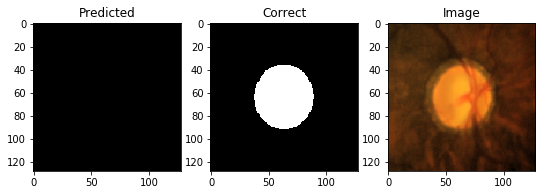

IOU: 0.0
Dice: 0.0
image #36


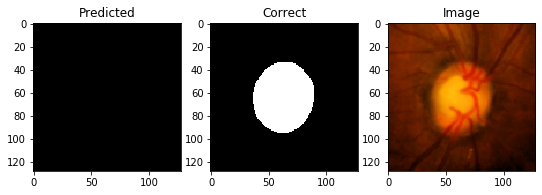

IOU: 0.0
Dice: 0.0
image #37


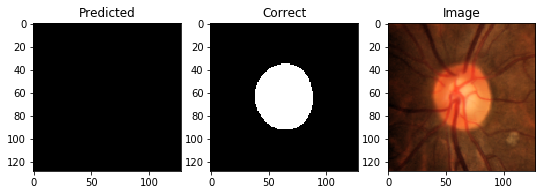

IOU: 0.0
Dice: 0.0
image #38


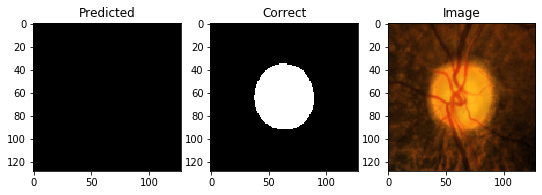

IOU: 0.0
Dice: 0.0
image #39


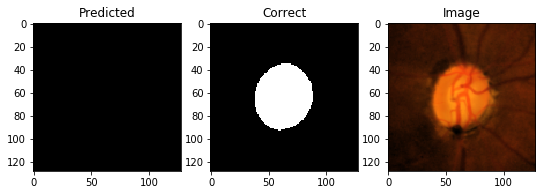

IOU: 0.0
Dice: 0.0
image #40


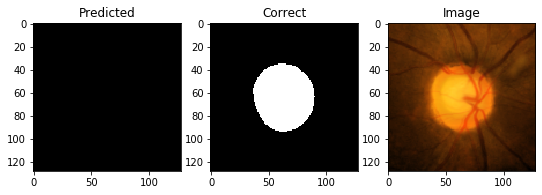

IOU: 0.0
Dice: 0.0
image #41


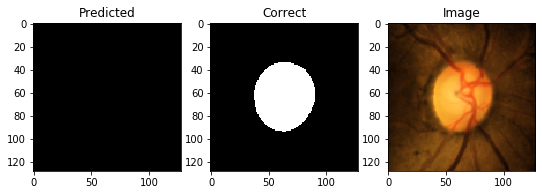

IOU: 0.0
Dice: 0.0
image #42


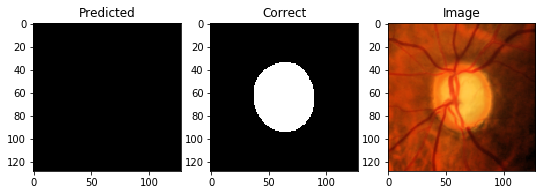

IOU: 0.0
Dice: 0.0
image #43


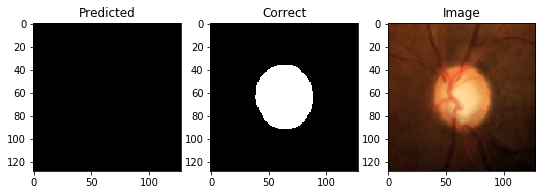

IOU: 0.0
Dice: 0.0
image #44


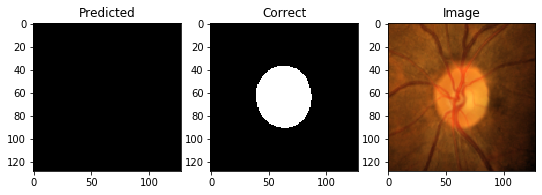

IOU: 0.0
Dice: 0.0
image #45


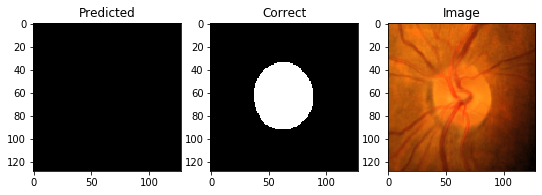

IOU: 0.0
Dice: 0.0
image #46


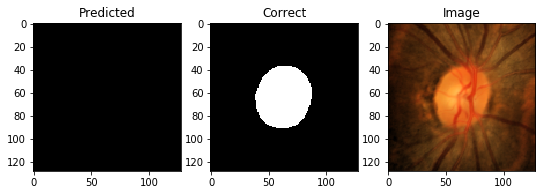

IOU: 0.0
Dice: 0.0
image #47


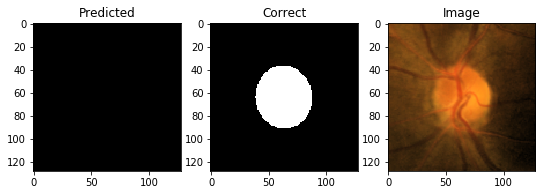

IOU: 0.0
Dice: 0.0
image #48


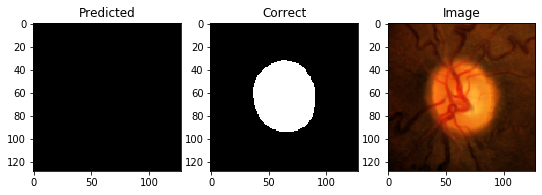

IOU: 0.0
Dice: 0.0
image #49


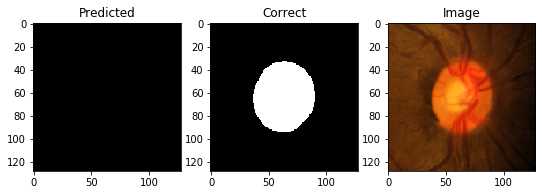

IOU: 0.0
Dice: 0.0


In [71]:
pred_iou, pred_dice = [], []
pred_disc = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_train[img_no]
    batch_X = X_valid[i:i + 1]
    batch_z = Z_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_disc.append(pred)
    corr = th_to_tf_encoding(batch_z)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [37]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.88481957
0.9318124774128806


In [38]:
def ellipseFitting(img):
    contours, hierarchy = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    ellipse = np.zeros(img.shape)
    diametro = []
    for ind, cont in enumerate(contours):
        (x,y),(MA,ma),angle = cv2.fitEllipse(cont)
        diametro.append((MA, ma))
        cv2.ellipse(ellipse,(int(x),int(y)),(int(MA/2), int(ma/2)),angle,0,360,(255,255,255),0)
    return ellipse, diametro

In [39]:
import cv2
cdrs = []
for i, img_no in enumerate(test_idx):
    cup = pred_cup[i]
    disc = pred_disc[i]
        
    c = cv2.Canny(cup.astype(np.uint8), 1,1)
    d = cv2.Canny(disc.astype(np.uint8), 1,1)
    
    el_c, diam_c = ellipseFitting(c)
    el_d, diam_d = ellipseFitting(d)
        
    if len(diam_d) > 0 and len(diam_c) > 0:
        cdr = diam_c[0][1]/diam_d[0][1]
        cdrs.append(cdr)
        print('image #{} - cdr = {}'.format(img_no, cdr))


image #0 - cdr = 0.7959553770044641
image #1 - cdr = 2.5943181844706773
image #2 - cdr = 0.7715123244327965
image #3 - cdr = 0.7152091702221255
image #4 - cdr = 0.7497682447155499
image #5 - cdr = 0.7275174564353213
image #6 - cdr = 0.8467512558832814
image #7 - cdr = 0.4260348274409503
image #8 - cdr = 0.7921016718303348
image #9 - cdr = 0.874442048338831
image #10 - cdr = 0.8320030462049364
image #11 - cdr = 0.8892464849475913
image #12 - cdr = 0.6806354395095642
image #13 - cdr = 0.7861529670340084
image #14 - cdr = 0.7250295149614733
image #15 - cdr = 0.8096947150863838
image #16 - cdr = 0.6951579714638968
image #17 - cdr = 0.6714348657741803
image #18 - cdr = 0.7042569022099471
image #19 - cdr = 0.7697079115555777
image #20 - cdr = 0.7154596743923402
image #21 - cdr = 0.8523058303931974
image #22 - cdr = 0.7416844636420372
image #23 - cdr = 0.726632927331785
image #24 - cdr = 0.8281362809368412
image #25 - cdr = 0.6668022996570586
image #26 - cdr = 0.7939083118706878
image #27 - c